In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from datetime import datetime
#from arsenic import get_session
#from arsenic.browsers import Firefox
#from arsenic.services import Geckodriver
import asyncio

# disable arsenic logging to stdout
#import structlog
#import logging

#logger = logging.getLogger()
#logger.setLevel(logging.WARN)
#structlog.configure(logger_factory=lambda: logger)

import spacy
from spacy.matcher import PhraseMatcher
import nltk
from nltk.stem import PorterStemmer
nltk.download('punkt')
from nltk import ngrams
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hcl
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:490: UserWarning: Can't initialize NVML
  def _raw_device_count_nvml() -> int:
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
!pip install -U spacy
!python -m spacy download en_core_web_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-04-06 01:08:09.514388: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-06 01:08:09.514500: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-06 01:08:09.514518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries.

#**Data Collection and Cleaning**

In [4]:
driver_path = 'C:\programs\geckodriver.exe'

options = {
  'moz:firefoxOptions': {
    'args': ['-headless'],
    'log': {'level': 'warn'},
    'binary': 'C:\\Program Files\\Mozilla Firefox\\firefox.exe'
  }
}

Collecting Job Postings

In [5]:
## Enter a job position
position = ("data scientist, machine learning engineer,"
          "data analyst,business analyst, business analytics consultant,"
          "risk analyst,Operations Research Analyst,Data Mining Engineer,"
          "Decision Scientist,Artificial Intelligence Specialist")
## Enter a location (City, State or Zip or remote)
locations = "USA"

def get_url(position, location):
    url_template = "https://www.indeed.com/jobs?q={}&l={}"
    url = url_template.format(position, location)
    return url

url = get_url(position, locations)
dataframe_USA = pd.DataFrame(columns=["Title", "Company", "Location", "Salary", "Links"])

In [6]:
'''
## Number of postings to scrape
postings = 1000

## Number of browser instances to use
n = 3

pages = list(range(0, int((postings/15)*10), 10))

state = {
  'lock': asyncio.Lock(),
  'ids': set(),
  'n': 0
}
             
async def get_jobs(url, pages, state):
  data = []
  async with get_session(Geckodriver(binary=driver_path, log_file=asyncio.subprocess.PIPE), Firefox(**options)) as session:
    for i in pages:
      await session.get(url + "&start=" + str(i))
      jobs = await session.get_elements("[class='job_seen_beacon']")

      for job in jobs:
        result_html = await job.get_property('innerHTML')
        soup = BeautifulSoup(result_html, 'html.parser')

        liens = await job.get_elements("a")
        link = await liens[0].get_attribute("href")

        title = soup.select('.jobTitle')[0].get_text().strip()
        try:
          company = soup.select('.companyName')[0].get_text().strip()
        except:
          continue
        location = soup.select('.companyLocation')[0].get_text().strip()
        try:
            salary = soup.select('.salary-snippet-container')[0].get_text().strip()
        except:
            salary = 'NaN'
                    
        Id = f"{title}{company}{location}{salary}"
        
        dupe = False
        async with state['lock']:
          if Id in state['ids']:
            dupe = True
          else:
            state['ids'].add(Id)
            state['n'] = state['n'] + 1
        if dupe:
          continue

        data.append({
          'Title': title,
          "Company": company,
          'Location': location,
          "Salary": salary,
          "Links": link
        })
  return data

tasks = [asyncio.create_task(get_jobs(url, p, state)) for p in np.array_split(pages, n)]
dataframe_USA = pd.DataFrame([j for task in tasks for j in await task])

'''

'\n## Number of postings to scrape\npostings = 1000\n\n## Number of browser instances to use\nn = 3\n\npages = list(range(0, int((postings/15)*10), 10))\n\nstate = {\n  \'lock\': asyncio.Lock(),\n  \'ids\': set(),\n  \'n\': 0\n}\n             \nasync def get_jobs(url, pages, state):\n  data = []\n  async with get_session(Geckodriver(binary=driver_path, log_file=asyncio.subprocess.PIPE), Firefox(**options)) as session:\n    for i in pages:\n      await session.get(url + "&start=" + str(i))\n      jobs = await session.get_elements("[class=\'job_seen_beacon\']")\n\n      for job in jobs:\n        result_html = await job.get_property(\'innerHTML\')\n        soup = BeautifulSoup(result_html, \'html.parser\')\n\n        liens = await job.get_elements("a")\n        link = await liens[0].get_attribute("href")\n\n        title = soup.select(\'.jobTitle\')[0].get_text().strip()\n        try:\n          company = soup.select(\'.companyName\')[0].get_text().strip()\n        except:\n          cont

In [7]:
'''
Links_list = dataframe_USA['Links'].tolist()

import random

async def get_description(urls):
  descriptions = []
  async with get_session(Geckodriver(binary=driver_path, log_file=asyncio.subprocess.PIPE), Firefox(**options)) as session:
    for url in urls:
      await session.get("https://www.indeed.com"+url)
      jd = await session.get_element('#jobDescriptionText')
      descriptions.append(await jd.get_text())
      await asyncio.sleep(random.random() * 1.5)
  return descriptions

## Number of browser instances to use
n = 4

tasks = [asyncio.create_task(get_description(urls)) for urls in np.array_split(Links_list, n)]
dataframe_USA['Descriptions'] = [desc for task in tasks for desc in await task]

dataframe_USA.to_csv('Job_Postings_USA.csv', index=False)
'''

'\nLinks_list = dataframe_USA[\'Links\'].tolist()\n\nimport random\n\nasync def get_description(urls):\n  descriptions = []\n  async with get_session(Geckodriver(binary=driver_path, log_file=asyncio.subprocess.PIPE), Firefox(**options)) as session:\n    for url in urls:\n      await session.get("https://www.indeed.com"+url)\n      jd = await session.get_element(\'#jobDescriptionText\')\n      descriptions.append(await jd.get_text())\n      await asyncio.sleep(random.random() * 1.5)\n  return descriptions\n\n## Number of browser instances to use\nn = 4\n\ntasks = [asyncio.create_task(get_description(urls)) for urls in np.array_split(Links_list, n)]\ndataframe_USA[\'Descriptions\'] = [desc for task in tasks for desc in await task]\n\ndataframe_USA.to_csv(\'Job_Postings_USA.csv\', index=False)\n'

In [8]:
## Enter a job position
position = ("data scientist, machine learning engineer,"
          "data analyst,business analyst, business analytics consultant,"
          "risk analyst,Operations Research Analyst,Data Mining Engineer,"
          "Decision Scientist,Artificial Intelligence Specialist")
## Enter a location (City, State or Zip or remote)
locations = "Canada"

def get_url(position, location):
    url_template = "https://ca.indeed.com/jobs?q={}&l={}"
    url = url_template.format(position, location)
    return url

url = get_url(position, locations)
dataframe_Canada = pd.DataFrame(columns=["Title", "Company", "Location", "Salary", "Links"])

In [9]:
'''
## Number of postings to scrape
postings = 600

## Number of browser instances to use
n = 3

pages = list(range(0, int((postings/15)*10), 10))

state = {
  'lock': asyncio.Lock(),
  'ids': set(),
  'n': 0
}
             
async def get_jobs(url, pages, state):
  data = []
  async with get_session(Geckodriver(binary=driver_path, log_file=asyncio.subprocess.PIPE), Firefox(**options)) as session:
    for i in pages:
      await session.get(url + "&start=" + str(i))
      jobs = await session.get_elements("[class='job_seen_beacon']")

      for job in jobs:
        result_html = await job.get_property('innerHTML')
        soup = BeautifulSoup(result_html, 'html.parser')

        liens = await job.get_elements("a")
        link = await liens[0].get_attribute("href")

        title = soup.select('.jobTitle')[0].get_text().strip()
        try:
          company = soup.select('.companyName')[0].get_text().strip()
        except:
          continue
        location = soup.select('.companyLocation')[0].get_text().strip()
        try:
            salary = soup.select('.salary-snippet-container')[0].get_text().strip()
        except:
            salary = 'NaN'
                    
        Id = f"{title}{company}{location}{salary}"
        
        dupe = False
        async with state['lock']:
          if Id in state['ids']:
            dupe = True
          else:
            state['ids'].add(Id)
            state['n'] = state['n'] + 1
        if dupe:
          continue

        data.append({
          'Title': title,
          "Company": company,
          'Location': location,
          "Salary": salary,
          "Links": link
        })
     # i = i + 10
  return data

tasks = [asyncio.create_task(get_jobs(url, p, state)) for p in np.array_split(pages, n)]
dataframe_Canada = pd.DataFrame([j for task in tasks for j in await task])

'''

'\n## Number of postings to scrape\npostings = 600\n\n## Number of browser instances to use\nn = 3\n\npages = list(range(0, int((postings/15)*10), 10))\n\nstate = {\n  \'lock\': asyncio.Lock(),\n  \'ids\': set(),\n  \'n\': 0\n}\n             \nasync def get_jobs(url, pages, state):\n  data = []\n  async with get_session(Geckodriver(binary=driver_path, log_file=asyncio.subprocess.PIPE), Firefox(**options)) as session:\n    for i in pages:\n      await session.get(url + "&start=" + str(i))\n      jobs = await session.get_elements("[class=\'job_seen_beacon\']")\n\n      for job in jobs:\n        result_html = await job.get_property(\'innerHTML\')\n        soup = BeautifulSoup(result_html, \'html.parser\')\n\n        liens = await job.get_elements("a")\n        link = await liens[0].get_attribute("href")\n\n        title = soup.select(\'.jobTitle\')[0].get_text().strip()\n        try:\n          company = soup.select(\'.companyName\')[0].get_text().strip()\n        except:\n          conti

In [10]:
'''
Links_list = dataframe_Canada['Links'].tolist()

import random

async def get_description(urls):
  descriptions = []
  async with get_session(Geckodriver(binary=driver_path, log_file=asyncio.subprocess.PIPE), Firefox(**options)) as session:
    for url in urls:
      await session.get("https://ca.indeed.com"+url)
      jd = await session.get_element('#jobDescriptionText')
      descriptions.append(await jd.get_text())
      await asyncio.sleep(random.random() * 1.5)
  return descriptions

## Number of browser instances to use
n = 4

tasks = [asyncio.create_task(get_description(urls)) for urls in np.array_split(Links_list, n)]
dataframe_Canada['Descriptions'] = [desc for task in tasks for desc in await task]

dataframe_Canada.to_csv('Job_Postings_Canada.csv', index=False)
'''

'\nLinks_list = dataframe_Canada[\'Links\'].tolist()\n\nimport random\n\nasync def get_description(urls):\n  descriptions = []\n  async with get_session(Geckodriver(binary=driver_path, log_file=asyncio.subprocess.PIPE), Firefox(**options)) as session:\n    for url in urls:\n      await session.get("https://ca.indeed.com"+url)\n      jd = await session.get_element(\'#jobDescriptionText\')\n      descriptions.append(await jd.get_text())\n      await asyncio.sleep(random.random() * 1.5)\n  return descriptions\n\n## Number of browser instances to use\nn = 4\n\ntasks = [asyncio.create_task(get_description(urls)) for urls in np.array_split(Links_list, n)]\ndataframe_Canada[\'Descriptions\'] = [desc for task in tasks for desc in await task]\n\ndataframe_Canada.to_csv(\'Job_Postings_Canada.csv\', index=False)\n'

In [11]:
# dataframe_USA=pd.read_csv('Job_Postings_USA.csv')
# dataframe_Canada=pd.read_csv('Job_Postings_Canada.csv')
# dataset=pd.concat([dataframe_USA,dataframe_Canada]).reset_index()
# dataset=dataset[['Title','Company','Location','Salary','Descriptions']]
# dataset.to_csv('webscraping_results.csv', index=False)

In [12]:
df=pd.read_csv('webscraping_results.csv')
DF=(pd.DataFrame(np.random.permutation(df),columns=df.columns)).copy(deep=True)
DF

,Title,Company,Location,Salary,Descriptions
0,Text Data Analyst,Autodesk,"Toronto, ON",NaN,Job Requisition ID #\n23WD68627\nText Data Ana...
1,Junior Business Data Analyst,TRESUME,"Woodbridge, VA 22191","$50,000 - $60,000 a year","Define and deliver metrics, reporting platform..."
2,"Analyst, Credit Investment Operations",CPP Investments,"Hybrid remote in Toronto, ON",NaN,Company Description\n\nMake an impact at a glo...
3,Data Analyst,Xiartech,"Detroit, MI","$50,733 - $102,386 a year",Must Have:\n· Bachelor's Degree required\n· 3-...
4,Data Analyst,MIDCONTINENT INDEPENDENT SYSTEM OPERATOR INC,"Eagan, MN 55121",NaN,MISO offers a comprehensive benefits package a...


#**EDA and Feature Engineering**

We will generate a list of technical and business skills

In [13]:
#Importing openai
try:
  import openai
except:
  !pip install openai
  import openai

In [14]:
#from google.colab import drive
#drive.mount('/content/drive')
#f = open("/content/drive/MyDrive/api_key.txt", "r")
f = open("/content/api_key.txt", "r")
API_KEY=f.readline()
f.close()

#The OpenAI Key
import os
os.environ['OPENAI_API_KEY'] =API_KEY
openai.api_key = os.getenv("OPENAI_API_KEY")


In [15]:
# Defining Skills Manually
skills_manual=['SQL','NoSQL','Pytorch','Azure','Matlab','Optimization','Simulation','Team Player','Story Telling','Critical Thinking','Adaptability']

In [16]:
# Code for asking Chat-GPT for a list of skills

##### Remove doc strings to run the code after providing API key in the above cell
'''  
# Asking Chat-GPT for a list of skills
prompt=('I am designing course curriculum for a new “Master of Business and '
          'Management in Data Science and Artificial Intelligence” program '
          'at a University. Please give me a list of relevant twenty technical skills '
          '(hard skills) and fifteen business skills (soft skills) that should be '
          'taught in this program')

response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
    {"role": "system", "content": "You are a helpful  assistant."},
    {"role": "user", "content": prompt},
    ],
    max_tokens=1024,
    n=1,
    stop=None,
    temperature=0.5,
)

if response["choices"][0]["finish_reason"] == "error":
    print(f"Error: {response['choices'][0]['text']}")
else:
    output = response['choices'][0]['message']['content']
    print(output)

'''

# Hard Coding Output from GPT 3.5 Turbo API , for consistency
output='''

Sure, here is a list of twenty technical skills (hard skills) and fifteen business skills (soft skills) that should be taught in a "Master of Business and Management in Data Science and Artificial Intelligence" program:

Technical Skills (Hard Skills):
1. Data Analysis and Visualization
2. Machine Learning
3. Deep Learning
4. Natural Language Processing
5. Computer Vision
6. Data Mining
7. Data Warehousing
8. Big Data Analytics
9. Cloud Computing
10. Distributed Systems
11. Statistical Analysis
12. Programming Languages (Python, R, Java, C++)
13. Data Modeling
14. Data Management
15. Data Security
16. Data Governance
17. Data Privacy
18. Data Ethics
19. Data Quality
20. Data Integration

Business Skills (Soft Skills):
1. Communication Skills
2. Leadership Skills
3. Project Management
4. Strategic Thinking
5. Critical Thinking
6. Decision Making
7. Teamwork and Collaboration
8. Business Acumen
9. Negotiation Skills
10. Problem Solving
11. Analytical Skills
12. Sales and Marketing
13. Financial Management
14. Relationship management
15. Risk Management

These skills will help students to develop a strong foundation in both technical and business knowledge, which is essential for succeeding in the field of data science and artificial intelligence.

'''

print(output)



Sure, here is a list of twenty technical skills (hard skills) and fifteen business skills (soft skills) that should be taught in a "Master of Business and Management in Data Science and Artificial Intelligence" program:

Technical Skills (Hard Skills):
1. Data Analysis and Visualization
2. Machine Learning
3. Deep Learning
4. Natural Language Processing
5. Computer Vision
6. Data Mining
7. Data Warehousing
8. Big Data Analytics
9. Cloud Computing
10. Distributed Systems
11. Statistical Analysis
12. Programming Languages (Python, R, Java, C++)
13. Data Modeling
14. Data Management
15. Data Security
16. Data Governance
17. Data Privacy
18. Data Ethics
19. Data Quality
20. Data Integration

Business Skills (Soft Skills):
1. Communication Skills
2. Leadership Skills
3. Project Management
4. Strategic Thinking
5. Critical Thinking
6. Decision Making
7. Teamwork and Collaboration
8. Business Acumen
9. Negotiation Skills
10. Problem Solving
11. Analytical Skills
12. Sales and Marketing
13. 

In [17]:
# Defining a combined list of skills from our manually defined list and
# taking ideas from the list given by GPT 3.5 API

Skills=['Python','Java','Javascript','C++','SQL','NoSQL','Pytorch','Keras','TensorFlow',
        'Cloud Platforms','GCP','Azure','AWS','Matlab','Data Analysis','Visualization','Dashboard',
        'Tableau','Power BI','Machine Learning','Deep Learning','Natural Language Processing',
        'Computer Vision','Data Mining', 'Data Warehousing', 'Big Data Analytics','Time Series',
        'Spark','Hadoop','Statistical Analysis', 'Data Management','Data Pipelines',
        'Data Security','Data Integration','Optimization','Simulation','Business Analytics',
        'optimization','Teamwork','Collaboration','Communication','Story Telling',
        'Leadership','Project Management','Strategic Thinking','Critical thinking',
        'Decision Making','Business Acumen','Negotiation Skills','adaptability',
        'Problem Solving','Analytical Skills','Sales and Marketing','Financial Management',
        'Relationship Management','Risk Management']

Extractig Skills,

In [18]:
nlp_model=spacy.load("en_core_web_md")

skills_comb=' '.join(Skills)
skills_split=skills_comb.split(' ')

# Creating a list of skills after stemming
porter = PorterStemmer()
Skills_stem=[porter.stem(s.lower()) for s in skills_split]

# Removing the word 'data' and 'and' as this can be too misleading for the tasks ahead
arr=np.array(Skills_stem)
idx=(arr!='data') & (arr!='and')
Skills_stem=arr[idx]

# Creating Patterns
patterns=[nlp_model(str(s)) for s in Skills_stem]

In [19]:
# Storing Approximate Skill Matches for Each Job Description
job_descriptions=DF['Descriptions']
approx_desc=[]

''' Takes about six minutes to run  '''
for desc in job_descriptions:

  doc=(desc.lower()).split(' ')
  doc=' '.join([(s.replace(',','')) for s in doc])
  doc=nlp_model(doc)
  doc_stem=' '.join([porter.stem(str(s)) for s in doc])
  doc_stem=nlp_model(doc_stem)

  matcher = PhraseMatcher(nlp_model.vocab)
  matcher.add('Job Skills',None,*patterns)
  

  matches=matcher(doc_stem)
  approx_skills=[]
  for m in matches:
    approx_skills.append(str((doc[m[1]-1:m[2]+1])))
  approx_skills=' '.join(approx_skills)
  approx_desc.append(approx_skills)

# The above process takes about six minutes to run

DF['Approx_Desc']=approx_desc
DF_Appr_Job=DF[['Title','Approx_Desc']]

By this process, we have reduced large texts of job descriptions to just a few lines which mention the job skills

In [20]:
# Printing Few Random Examples for illustration
print(DF_Appr_Job['Approx_Desc'][75])
print('\n')
print(DF_Appr_Job['Approx_Desc'][271])
print('\n')
print(DF_Appr_Job['Approx_Desc'][368])

a collaborative and we solve business solve business problems business problems through people process and software projects designed -time streaming streaming pipelines that ml pipelines and data pipelines for data processing and data warehousing
 and optimize the deploying machine learning machine learning algorithms and collaborate with data management and understand business objectives web3 community. in computer science utilizing java or or python. in computer science on machine learning machine learning and programming skills ( (python java python java or in sql and and nosql databases with big data data platforms such ray spark or with cloud providers (gcp azure gcp azure or or aws) related skills experience


machine learning and learning and robotics machine learning ( learning (ml natural language processing language processing computer processing computer vision computer vision and vision and multi make progress on simulation and prior machine learning. learning. you simulat

Next, we will make N-grams of these shorter texts and then we shall check if skills in our master list are present in these N-grams

In [21]:
DF_Appr_Job['Desc_Token']=DF_Appr_Job['Approx_Desc'].apply(lambda x: nltk.word_tokenize(x))
DF_Appr_Job['Desc_Bi-Grams']=DF_Appr_Job['Desc_Token'].apply(lambda x: list(ngrams(x, 2)))
DF_Appr_Job=(DF_Appr_Job[['Title','Approx_Desc','Desc_Bi-Grams']]).copy(deep=True)

<ipython-input-21-b7ff40db2a99>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_Appr_Job['Desc_Token']=DF_Appr_Job['Approx_Desc'].apply(lambda x: nltk.word_tokenize(x))
<ipython-input-21-b7ff40db2a99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_Appr_Job['Desc_Bi-Grams']=DF_Appr_Job['Desc_Token'].apply(lambda x: list(ngrams(x, 2)))


In [22]:
skills=[s.lower() for s in Skills]
skills_oneword=[s for s in skills if len(s.split(' '))==1]
skills_oneword_st=[porter.stem(s) for s in skills_oneword]
skills_other=[s for s in skills if len(s.split(' '))!=1]
skills_other_text=' '.join([s for s in skills_other])
skills_other_split=skills_other_text.split(' ')
skills_other_split=[porter.stem(s) for s in skills_other_split]

Until now, we have determined if a skill, which is a one word expression, is present in a job description by simply checking if the stemmed word of skill is present in job description.     
But, we cannot use the same approach for a two word skill extraction. Because say, for a skill named 'cloud platforms', we would want to match 'cloud services' but not 'cloud data' or 'cloud storage'.

First, we shall filter those bi-grams of job description which contain at least one word which matches with a word in skill name.

In [23]:
def filter_ngrams (list_):
  bi_grams=[] 
  for bg in list_:
    if (porter.stem(bg[0]) in skills_other_split ) or (porter.stem(bg[1]) in skills_other_split):
      bi_grams.append(' '.join([bg[0],bg[1]]))
  return bi_grams

In [24]:
DF_Appr_Job['Bi-Grams_Filtered']=DF_Appr_Job['Desc_Bi-Grams'].apply(lambda x: filter_ngrams(x))

for i in range(0,len(skills_oneword)):
  DF_Appr_Job[skills_oneword[i]]=DF_Appr_Job['Approx_Desc'].apply(lambda x: int(skills_oneword_st[i] in x) )

DF_Appr_Job=DF_Appr_Job.drop(columns=['Approx_Desc','Desc_Bi-Grams'])

In [25]:
DF_Appr_Job.head()

,Title,Bi-Grams_Filtered,python,java,javascript,c++,sql,nosql,pytorch,keras,...,tableau,spark,hadoop,optimization,simulation,teamwork,collaboration,communication,leadership,adaptability
0,Text Data Analyst,"[of making, making sense, for mining, mining a...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Junior Business Data Analyst,"[reporting platforms, platforms dashboards, da...",0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,1,0,0
2,"Analyst, Credit Investment Operations","[make an, under management, management valued,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
3,Data Analyst,"[in project, project management, management pr...",0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,1,0
4,Data Analyst,"[help manage, manage miso, team manage, manage...",1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [26]:
print(DF_Appr_Job['Bi-Grams_Filtered'][0])
print('\n')
print(DF_Appr_Job['Bi-Grams_Filtered'][10])

['of making', 'making sense', 'for mining', 'mining a', 'identify business', 'business requirements', 'develop analytical', 'analytical strategies', 'text analytics', 'analytics models', 'text analytics', 'analytics insights', 'text analytics', 'analytics strong', 'strong analytical', 'analytical and', 'and and', 'and critical', 'critical thinking', 'thinking critical', 'critical thinking', 'thinking skills', 'skills thinking', 'thinking skills', 'skills text', 'text analytics', 'analytics tools', 'of machine', 'machine learning', 'learning machine', 'machine learning', 'learning algorithms', 'algorithms and', 'and statistical', 'statistical analysis', 'analysis statistical', 'statistical analysis', 'analysis techniques', 'communication skills', 'skills communication', 'communication skills', 'skills both', '-solving skills', 'skills solving', 'solving skills', 'skills and', 'and of', 'communication skills', 'skills communication', 'communication skills', 'skills and', 'and see', 'see 

In [27]:
# Asking Chat-GPT for matching skills from filtered bi-grams

# Putting the code under docstrings as we do not need to run it again
'''
responses_=[]
skill_=str(skills_other)

for i in range(1045,len(DF_Appr_Job['Bi-Grams_Filtered'])):
    list_bigrams=str(DF_Appr_Job['Bi-Grams_Filtered'][i])

    prompt=('This is list1, a list of bi-grams separated by comma : {list1} '  
        '\n I need just one response either 0 or 1 for my input which is the entire list1 ' 
        '\n Please output 1 if you find almost an exact match of this skill: "{sk}", with a particular bi-gram in list1, else output 0 \n'
        'Requirement for a match :  At least one word should be common between the skill and bi-gram \n'
        'for example, output for "cloud platforms" should be 1 only if the words "cloud" or "platform" are found in bi-gram  '
        '\n Now repeat this process for all remaining skills in list2 which is: {list2}'
        '\n Please do not include any words in output, only 0\'s or 1\'s separated by comma'
        '\n total number of 0\'s or 1\'s in your response should be 30, same as the length of list2 '
        '\n Do not include any explanation or description in output')
    prompt=prompt.format(list1=list_bigrams,sk=skills_other[0],list2=skill_)

    response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=[
      {"role": "system", "content": "You are a helpful  assistant."},
      {"role": "user", "content": prompt},
      ],
      max_tokens=1024,
      n=1,
      stop=None,
      temperature=0.5,
      )

    if response["choices"][0]["finish_reason"] == "error":
      output=''
    else:
      output = response['choices'][0]['message']['content']
      responses_.append(output)
    time.sleep(1.6)   # To avoid maximum Rate Per Minute Error

'''

# Hard Coding a sample response from Chat GPT for one list of bi-grams
sample_response='1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,1,0,0,0,1,1,1,1,0'
print('sample response for 1 API call from Chat GPT is :\n',sample_response)

sample response for 1 API call from Chat GPT is :
 1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,1,0,0,0,1,1,1,1,0


In [28]:
# The above process takes about one hour to complete
# So, we save the result in a file and read it for all future uses
'''
extracted_skills=np.zeros((len(responses),len(skills_other)))
for k in range(0,len(responses)):
  l=responses[k].split(',')
  l=l[0:30]  # rarely, Chat GPT gives more than 30 responses, covering that rare situation
  l=np.array([int(i) for i in l])
  extracted_skills[k,:]=l

# This is a dataframe of extracted skills by Chat GPT for the skills which were two words
df_extr_skill=pd.DataFrame(data=extracted_skills,columns=skills_other) 

# Combining Dataframes of extracted skills for both one word and two words
DF_Skills_Extracted=pd.concat([DF_Appr_Job,df_extr_skill],axis=1)
DF_Skills_Extracted=DF_Skills_Extracted.drop(columns=['Bi-Grams_Filtered'])
DF_Skills_Extracted.to_csv('DF_Skills_Extracted.csv',sep=',',index=False)

'''

DF_Skills_Extracted=pd.read_csv('DF_Skills_Extracted.csv')
DF_Skills_Extracted.head()

,Title,python,java,javascript,c++,sql,nosql,pytorch,keras,tensorflow,...,critical thinking,decision making,business acumen,negotiation skills,problem solving,analytical skills,sales and marketing,financial management,relationship management,risk management
0,Business Systems Analyst I,0,0,0,0,1,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Business Intelligence Analyst I,1,0,0,0,1,0,0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Business Analyst,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Data Analyst (Go-To-Market),0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Senior Business Intelligence Analyst,0,0,0,0,1,0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


We will group the below columns together:         
1) Cloud Platforms, Azure, GCP, AWS    as 'Cloud platforms'         
2) pytorch, keras, tensorflow          as 'deep learning frameworks'         
3) teamwork, collaboration            as  'teamwork'        
4) tableau, power bi, visualization, dashboard     as 'data visualization'      

In [29]:
DF_tmp=(DF_Skills_Extracted[['cloud platforms','gcp', 'azure', 'aws']]).copy(deep=True)
DF_Skills_Extracted=DF_Skills_Extracted.drop(columns=['cloud platforms','gcp', 'azure', 'aws'])
DF_Skills_Extracted['cloud platforms']=np.max(DF_tmp,axis=1)

DF_tmp=(DF_Skills_Extracted[['pytorch','keras', 'tensorflow']]).copy(deep=True)
DF_Skills_Extracted=DF_Skills_Extracted.drop(columns=['pytorch','keras', 'tensorflow'])
DF_Skills_Extracted['deep learning frameworks']=np.max(DF_tmp,axis=1)

DF_tmp=(DF_Skills_Extracted[['teamwork','collaboration']]).copy(deep=True)
DF_Skills_Extracted=DF_Skills_Extracted.drop(columns=['teamwork','collaboration'])
DF_Skills_Extracted['teamwork']=np.max(DF_tmp,axis=1)

DF_tmp=(DF_Skills_Extracted[['tableau','power bi','dashboard','visualization']]).copy(deep=True)
DF_Skills_Extracted=DF_Skills_Extracted.drop(columns=['tableau','power bi','dashboard','visualization'])
DF_Skills_Extracted['data visualization']=np.max(DF_tmp,axis=1)

In [30]:
# Text processing title column
DF_Skills_Extracted['Title'] = DF_Skills_Extracted['Title'].apply(lambda x: " ".join(x.lower() for x in x.split()))
idx=DF_Skills_Extracted['Title'].str.contains('scientist')
DF_Skills_Extracted['Title'][idx]='data scientist'
idx_1=DF_Skills_Extracted['Title'].str.contains('business')
idx_2=DF_Skills_Extracted['Title'].str.contains('analy')
idx=idx_1 & idx_2
DF_Skills_Extracted['Title'][idx]='business analyst'
idx_1=DF_Skills_Extracted['Title'].str.contains('data')
idx_2=DF_Skills_Extracted['Title'].str.contains('analy')
idx=idx_1 & idx_2
DF_Skills_Extracted['Title'][idx]='data analyst'
idx_1=DF_Skills_Extracted['Title'].str.contains('operations')
idx_2=DF_Skills_Extracted['Title'].str.contains('analy')
idx=idx_1 & idx_2
DF_Skills_Extracted['Title'][idx]='operations analyst'
idx_1=DF_Skills_Extracted['Title'].str.contains('data')
idx_2=DF_Skills_Extracted['Title'].str.contains('engineer')
idx=idx_1 & idx_2
DF_Skills_Extracted['Title'][idx]='data engineer'
idx=DF_Skills_Extracted['Title'].str.contains('machine learning')
DF_Skills_Extracted['Title'][idx]='machine learning engineer'
idx=DF_Skills_Extracted['Title'].str.contains('consultant')
DF_Skills_Extracted['Title'][idx]='consultant'
idx_1=DF_Skills_Extracted['Title'].str.contains('market')
idx_2=DF_Skills_Extracted['Title'].str.contains('analy')
idx=idx_1 & idx_2
DF_Skills_Extracted['Title'][idx]='market analyst'
idx_1=DF_Skills_Extracted['Title'].str.contains('risk')
idx_2=DF_Skills_Extracted['Title'].str.contains('analy')
idx=idx_1 & idx_2
DF_Skills_Extracted['Title'][idx]='risk analyst'
idx_1=DF_Skills_Extracted['Title'].str.contains('finan')
idx_2=DF_Skills_Extracted['Title'].str.contains('analy')
idx=idx_1 & idx_2
DF_Skills_Extracted['Title'][idx]='financial analyst'
idx_1=DF_Skills_Extracted['Title'].str.contains('project')
idx_2=DF_Skills_Extracted['Title'].str.contains('manage')
idx=idx_1 & idx_2
DF_Skills_Extracted['Title'][idx]='project manager'
idx_1=DF_Skills_Extracted['Title'].str.contains('product')
idx_2=DF_Skills_Extracted['Title'].str.contains('manage')
idx=idx_1 & idx_2
DF_Skills_Extracted['Title'][idx]='product manager'
idx=DF_Skills_Extracted['Title'].str.contains('stat')
DF_Skills_Extracted['Title'][idx]='statistician'
idx=DF_Skills_Extracted['Title'].str.contains('software')
DF_Skills_Extracted['Title'][idx]='software engineer'

<ipython-input-30-60b7d400adf1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_Skills_Extracted['Title'][idx]='data scientist'
<ipython-input-30-60b7d400adf1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_Skills_Extracted['Title'][idx]='business analyst'
<ipython-input-30-60b7d400adf1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_Skills_Extracted['Title'][idx]='data analyst'
<ipython-input-30-60b7d400adf1>:16: Settin

In [31]:
DF_Skills_Extracted.head()

,Title,python,java,javascript,c++,sql,nosql,matlab,spark,hadoop,...,problem solving,analytical skills,sales and marketing,financial management,relationship management,risk management,cloud platforms,deep learning frameworks,teamwork,data visualization
0,business analyst,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0
1,business analyst,1,0,0,0,1,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0
2,business analyst,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.0
3,data analyst,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.0
4,business analyst,0,0,0,0,1,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,1.0


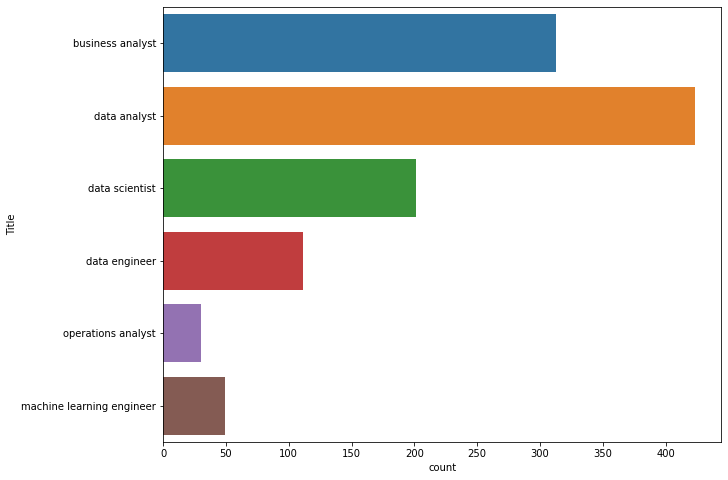

In [32]:
# First, lets see which role is in most demand
counts = DF_Skills_Extracted['Title'].value_counts()
counts = counts[counts >= 30]
DF_filtered = DF_Skills_Extracted[DF_Skills_Extracted['Title'].isin(counts.index)]

plt.rcParams["figure.figsize"] = [10,8]
sns.countplot(data=DF_filtered,y='Title')
plt.show()

Data Analyst Role is in most demand followed by Business Analyst

In [33]:
# Next, we should observe the number of skills 

DF_tmp=(DF_filtered).copy(deep=True)
DF_filtered['skill count']=np.sum(DF_tmp,axis=1)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return reduction(axis=axis, out=out, **passkwargs)
<ipython-input-33-1865b6ec6323>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_filtered['skill count']=np.sum(DF_tmp,axis=1)


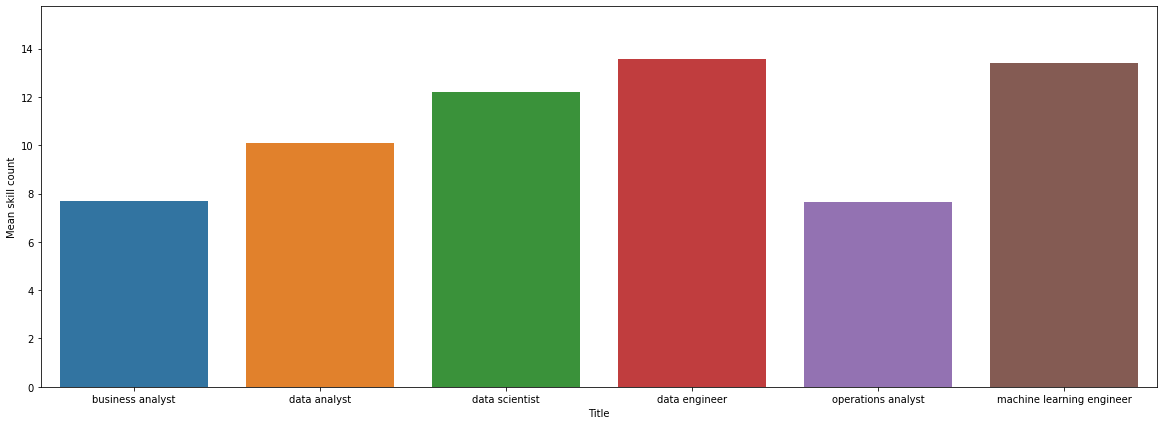

In [34]:
plt.rcParams["figure.figsize"] = [20,7]
sns.barplot(data=DF_filtered,errwidth=0.0,x='Title',y='skill count')
plt.ylabel('Mean skill count')
plt.show()

On an average, around 8-12 skills are required for data roles, with highest required for data engineer followed by machine learning engineer

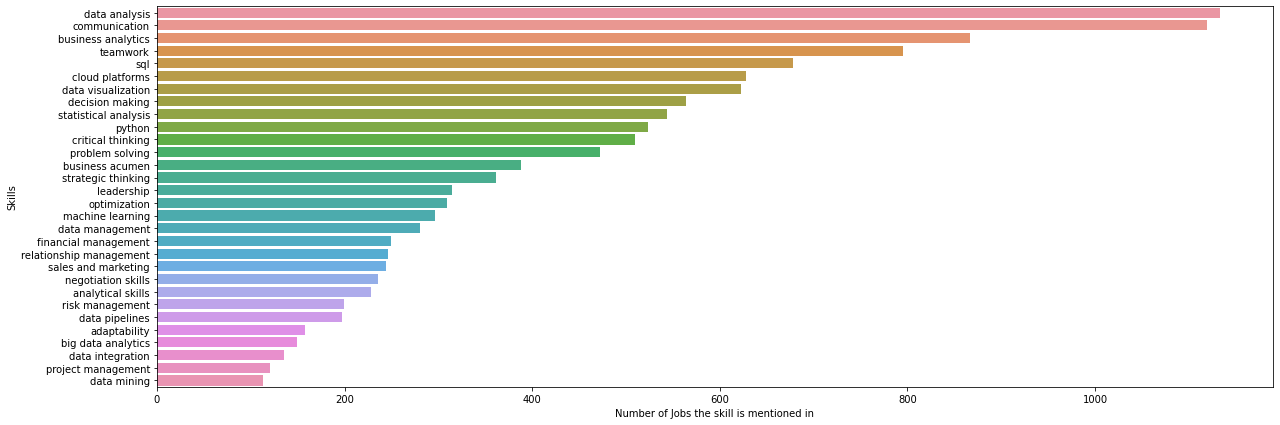

In [35]:
# We should see which skill is in most demand
DF_=(DF_Skills_Extracted.iloc[:,1:]).copy(deep=True)
DF_=np.sum(DF_,axis=0)
skills=np.array(DF_.index)
count=DF_.values
idx=count.argsort()[::-1][0:30]
count_ordered=count[idx]
skills_ordered=skills[idx]
DF_plot=pd.DataFrame({'Skills': skills_ordered, 'Count': count_ordered})
plt.rcParams["figure.figsize"] = [20,7]
sns.barplot(data=DF_plot,errwidth=0.0,x='Count',y='Skills')
plt.xlabel('Number of Jobs the skill is mentioned in')
plt.show()

For further analysis, we shall keep only the top 40 skills, and only the jobs which have listed at least 4 skills

In [36]:
DF_=(DF_Skills_Extracted.iloc[:,1:]).copy(deep=True)
DF_=np.sum(DF_,axis=0)
skills=np.array(DF_.index)
count=DF_.values
idx=count.argsort()[::-1][0:40]
skills_ordered=list(skills[idx])
DF=(DF_Skills_Extracted[skills_ordered]).copy(deep=True)
DF_=(DF).copy(deep=True)
DF_=np.sum(DF_,axis=1)
idx=DF_>4
DF=(((DF[idx].reset_index()).iloc[:,1:]).astype(int)).copy(deep=True)
DF

,data analysis,communication,business analytics,teamwork,sql,cloud platforms,data visualization,decision making,statistical analysis,python,...,java,spark,data warehousing,data security,deep learning frameworks,simulation,deep learning,story telling,hadoop,natural language processing
0,1,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,0,1,0,0,1,1,...,0,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1132,1,1,0,1,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1133,0,0,0,1,0,1,1,0,1,0,...,1,0,0,0,1,0,1,1,0,1
1134,1,1,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1135,1,0,1,0,0,0,0,1,1,1,...,0,0,0,0,0,1,0,0,0,0


#**Hierarchical Clustering**

In [37]:
# Dropping more skills which have very few jobs in common
DF_Hier=DF.copy(deep=True)
DF_Hier=DF_Hier.drop(columns=['story telling','hadoop','data security','project management','simulation','data warehousing'])

# Creating a Matrix which gives the number of jobs in common between skills
matrix_common_jobs = (DF_Hier.T).dot(DF_Hier)

In [38]:
diag_elem=np.diag(matrix_common_jobs)
# Creating distance matrix
DF_=matrix_common_jobs.copy(deep=True)
for i in range(0,len(DF_)):
    diag = diag_elem[i]
    for j in range(i,len(DF_)):
      DF_.iloc[i, j] /= diag 
    for j in range(i+1,len(DF_)):
      DF_.iloc[j, i] /= diag 
DF_=1/DF_
distance_matrix=DF_-1
distance_matrix

,data analysis,communication,business analytics,teamwork,sql,cloud platforms,data visualization,decision making,statistical analysis,python,...,data pipelines,adaptability,big data analytics,data integration,data mining,java,spark,deep learning frameworks,deep learning,natural language processing
data analysis,0.000000,0.205036,0.608000,0.618357,0.694772,0.932692,0.814079,1.001992,1.076446,1.098121,...,4.491803,7.305785,6.335766,7.739130,8.054054,10.292135,10.823529,14.227273,16.946429,24.769231
communication,0.205036,0.000000,0.572139,0.519231,0.798861,0.938650,0.880952,1.029979,1.199536,1.284337,...,5.493151,6.074627,7.777778,9.085106,10.285714,10.703704,14.290323,16.236364,18.346939,28.625000
business analytics,0.608000,0.572139,0.000000,0.604545,0.833766,0.966574,0.862797,0.934247,1.779528,1.434483,...,6.060000,6.932584,9.382353,9.382353,11.607143,10.966102,16.650000,19.764706,21.774194,36.157895
teamwork,0.618357,0.519231,0.604545,0.000000,0.817481,0.855643,0.822165,0.953039,1.061224,1.280645,...,4.795082,5.733333,6.000000,7.837500,10.403226,9.552239,11.403509,13.729167,17.128205,21.093750
sql,0.694772,0.798861,0.833766,0.817481,0.000000,0.685039,0.528571,1.031646,1.084416,0.577396,...,3.686131,8.727273,5.173077,5.978261,7.025000,7.675676,7.916667,15.461538,21.137931,28.181818
cloud platforms,0.932692,0.938650,0.966574,0.855643,0.685039,0.000000,0.744807,0.960000,1.092527,0.724340,...,3.523077,6.945946,3.900000,5.837209,8.800000,7.054795,6.736842,9.690909,11.000000,16.818182
data visualization,0.814079,0.880952,0.862797,0.822165,0.528571,0.744807,0.000000,0.899054,1.006667,0.917197,...,4.375000,7.361111,6.432099,7.026667,6.253012,9.750000,13.333333,22.153846,23.080000,24.083333
decision making,1.001992,1.029979,0.934247,0.953039,1.031646,0.960000,0.899054,0.000000,0.757862,1.078067,...,5.142857,5.576471,5.142857,8.316667,5.901235,8.982143,10.180000,15.441176,14.971429,18.275862
statistical analysis,1.076446,1.199536,1.779528,1.061224,1.084416,1.092527,1.006667,0.757862,0.000000,0.804124,...,4.250000,7.076923,3.861111,8.545455,4.526316,7.203125,7.898305,8.722222,9.500000,14.000000
python,1.098121,1.284337,1.434483,1.280645,0.577396,0.724340,0.917197,1.078067,0.804124,0.000000,...,3.146341,7.947368,3.811321,6.500000,6.727273,4.795455,5.219512,7.500000,9.408163,15.451613


<ipython-input-39-a795168260dd>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_mat=hcl.linkage(distance_matrix,method='centroid')


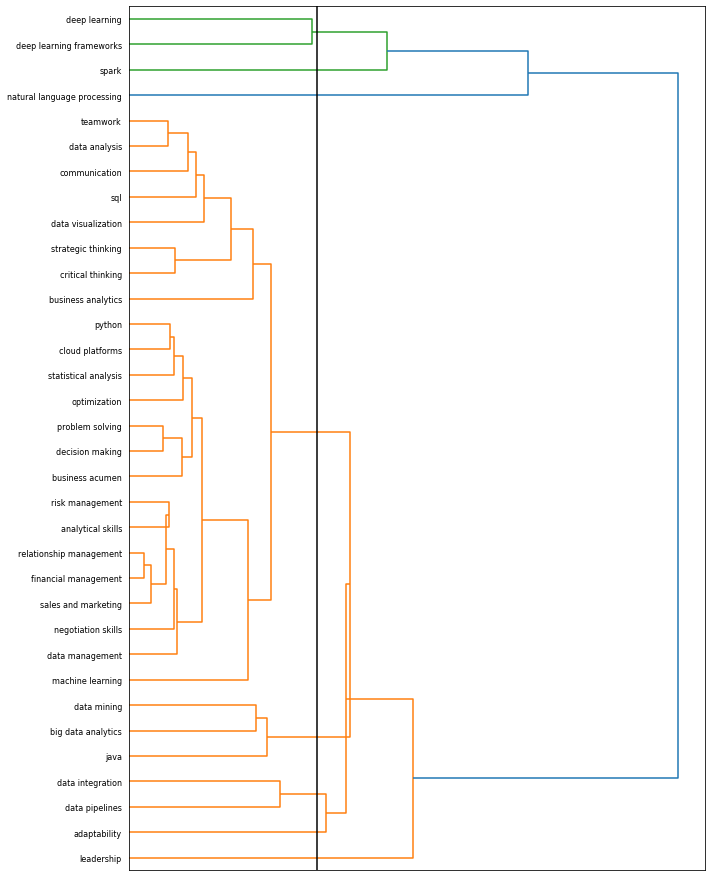

In [39]:
linkage_mat=hcl.linkage(distance_matrix,method='centroid')

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])

Dngm = hcl.dendrogram(linkage_mat, orientation='right')

labels = distance_matrix.columns[Dngm['leaves']]

ax1.set_xticks([])
ax1.set_yticklabels(labels)
plt.plot()
x=np.ones(500)*24
y=np.arange(0,500,1)
plt.plot(x,y,color='black')
plt.show()

Design of Course Curriculum :

Based on Dendrogram / Clustering results, the topics in courses can be grouped as follows:     

Course 1 : Neural Networks, Deep Learning, Deep Learning Frameworks    
Course 2: Distributed Computing, Spark, Hadoop    
Course 3: Natural Language Processing, Sentiment Analysis in NLP, Clustering in NLP    
Course 4: SQL, Data Visulaization, Business Analytics, Data Analysis, Strategic Thinking           
Course 5: Python, Cloud Platforms, Statistical Analysis, Optimization, Decision Making        
Course 6: Risk Management, Financial Management, Relationship Management, Negotiation Skills, Sales and Marketing        
Course 7: Data Mining, Big Data Analytics, Java        
Course 8: Data Integration, Data Pipelines, Data Engineering      

#**K Means Clustering Implementation**

In this part, we need to engineer features for skills.
First, we shall try to convert the distance metric used in Part 3 into a feature.    
This distance metric cannot be used directly as a feature, because it is only relative between a pair of skills. So, in order to convert it into a feature, we need to transform it onto a scale.    
For that, we will use below approach.    


(1) First, we will subtract successive columns of distance matrix above, and take mean of differences. This value will represent a measure of distance between that pair of skills considering all other skills into the picture.   
(2) Using this distance, we will put all skills on a scale taking first skill as a reference.

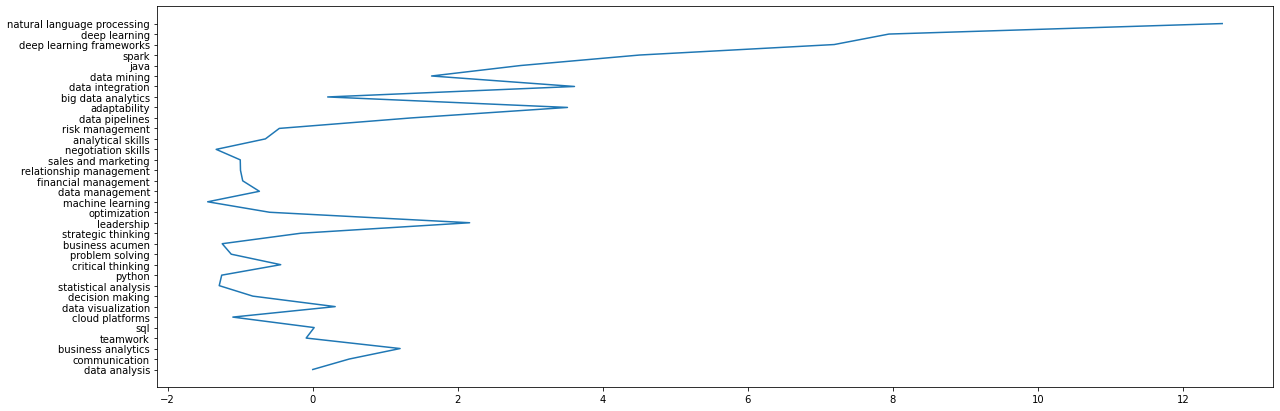

In [40]:
# Feature 1

# So, subtracting successive columns of distance matrix
diff_arr=np.zeros((distance_matrix.shape[0],distance_matrix.shape[0]-1))
for i in range(0,distance_matrix.shape[1]-1):
  diff_arr[:,i]=( distance_matrix.iloc[:,i+1] - distance_matrix.iloc[:,i] ).values 

#Taking mean of difference
diff_=np.mean(diff_arr,axis=0)

distance_metric=np.zeros(distance_matrix.shape[0])

for i in range(0, len(distance_metric)-1):
  distance_metric[i+1]=distance_metric[i]+diff_[i]

# Creating Visualization of distance metric
plt.plot(distance_metric,distance_matrix.columns)
plt.show()

In [41]:
# Feature 2
# This feature represent whether the skill is technical skill(hard skill) or business skill(soft skill)
tech_or_busns=np.array([1,0,1,0,1,1,1,0,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1])

In [42]:
# Feature 3
# Skill Frequency
skill_frequency=np.sum(DF_Hier,axis=0).values

In [43]:
# Feature 4
# Assigning Value as per job title/ role using below approach

# If skill mentioned only in Operations Analyst Job role - we assign weight 1
# If skill mentioned only in Data Engineer Job role - we assign weight 2
# If skill mentioned only in Business Analyst Job role - we assign weight 3
# If skill mentioned only in Data Analyst Job role - we assign weight 4
# If skill mentioned only in Machine Learning Engineer Job role - we assign weight 5
# If skill mentioned only in Data Scientist Job role - we assign weight 6


DF_=DF_Skills_Extracted.copy(deep=True)
weights= {"operations analyst": 1, 
         "data engineer": 3, 
         "business analyst": 6,
         "data analyst":12,
         "machine learning engineer":20,
         "data scientist":40}

def get_skill_score(skill):
  id=(DF_[skill]==1)
  df=DF_[id]

  roles=['operations analyst','data engineer','business analyst',
         'data analyst','machine learning engineer','data scientist']
  
  scores=np.zeros(len(roles))
  for i in range(0, len(roles)):
    idx=(df['Title']==roles[i])
    scores[i]=len(df[idx])*(weights[roles[i]])

  score=(np.sum(scores)/len(df))*10     # Normalizing , because we have already accounted for skill frequency in another feature

  return score


skill_scores=np.zeros(distance_matrix.shape[0])

for i in range(0, len(skill_scores)):
  skill_scores[i]=get_skill_score(distance_matrix.columns[i])

In [44]:
# Feature 5
# Number of unique job roles in which the skill is mentioned
# This is an indication of how genral or specific the skill is

DF_=DF_Skills_Extracted.copy(deep=True)
num_unique_role=np.zeros(distance_matrix.shape[0])
for i in range(0, len(num_unique_role)):
  id=(DF_[distance_matrix.columns[i]]==1)
  df=DF_[id]
  num_unique_role[i]=len(np.unique(df['Title']))

In [45]:
# Feature 6
# Maximum number of times the skill mentioned for a given job role
DF_=DF_Skills_Extracted.copy(deep=True)

def get_skill_max(skill):
  id=(DF_[skill]==1)
  df=DF_[id]

  roles=['operations analyst','data engineer','business analyst',
         'data analyst','machine learning engineer','data scientist']
  
  max=np.zeros(len(roles))
  for i in range(0, len(roles)):
    idx=(df['Title']==roles[i])
    max[i]=len(df[idx])

  max_=np.max(max)    

  return max_


role_max=np.zeros(distance_matrix.shape[0])

for i in range(0, len(role_max)):
  role_max[i]=get_skill_max(distance_matrix.columns[i])

In [46]:
# Feature 7
# Average number of times the skill mentioned for a given job role
DF_=DF_Skills_Extracted.copy(deep=True)

def get_skill_avg(skill):
  id=(DF_[skill]==1)
  df=DF_[id]

  roles=['operations analyst','data engineer','business analyst',
         'data analyst','machine learning engineer','data scientist']
  
  avg=np.zeros(len(roles))
  for i in range(0, len(roles)):
    idx=(df['Title']==roles[i])
    avg[i]=len(df[idx])

  avg_=np.mean(avg)    

  return avg_


role_avg=np.zeros(distance_matrix.shape[0])

for i in range(0, len(role_avg)):
  role_avg[i]=get_skill_avg(distance_matrix.columns[i])

In [47]:
# Feature 8
# On an average how many other skills are required when the skill is mentioned

DF_=DF_Skills_Extracted.copy(deep=True)
DF_=DF_.drop(columns=['Title'])

def get_other_avg(skill):
  df=DF_.copy(deep=True)
  id=(df[skill]==1)
  df=df[id]
  df=df.drop(columns=[skill])

  sum=np.sum(df,axis=1)
  avg_=np.mean(sum)    

  return avg_


other_avg=np.zeros(distance_matrix.shape[0])

for i in range(0, len(other_avg)):
  other_avg[i]=get_other_avg(distance_matrix.columns[i])

In [48]:
# Feature 9
# Minimum number of other skills required when the skill is mentioned
# This is an indication of how advanced the skill is

DF_=DF_Skills_Extracted.copy(deep=True)
DF_=DF_.drop(columns=['Title'])

def get_other_min(skill):
  df=DF_.copy(deep=True)
  id=(df[skill]==1)
  df=df[id]
  df=df.drop(columns=[skill])

  sum=np.sum(df,axis=1)
  min_=np.min(sum)    

  return min_


other_min=np.zeros(distance_matrix.shape[0])

for i in range(0, len(other_min)):
  other_min[i]=get_other_min(distance_matrix.columns[i])

In [49]:
# Feature 10
# On an average how many other technical skills are required along with the skill

DF_=DF_Skills_Extracted.copy(deep=True)
DF_=DF_.drop(columns=['Title'])

def get_other_techavg(skill):
  id=(DF_[skill]==1)
  df=DF[id]
  idx=(tech_or_busns==1)
  list_tech_skills=list(distance_matrix.columns[idx])
  if skill in list_tech_skills:
    list_tech_skills.remove(skill)
    req_cols=list_tech_skills
  else:
    req_cols=list_tech_skills

  df=df[req_cols]
  sum=np.sum(df,axis=1)
  avg_=np.mean(sum)    
  return avg_

other_techavg=np.zeros(distance_matrix.shape[0])

for i in range(0, len(other_techavg)):
  other_techavg[i]=get_other_techavg(distance_matrix.columns[i])

<ipython-input-49-212c6545bee3>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=DF[id]


In [50]:
# Making Dataset with engineered features 

data={'Skill':distance_matrix.columns, 'Distance_Metric':distance_metric,
      'Hard_or_Soft_Skill':tech_or_busns,'Skill_Frequency':skill_frequency,
      'Skill_Score':skill_scores,'Num_Unique_Roles':num_unique_role,
      'Max_Mention_Role':role_max,'Avg_Mention_Role':role_avg,
      'Avg_Mention_Other':other_avg,'Min_Mention_Other':other_min,
      'Avg_Other_Tech':other_techavg}
DF_Skills=pd.DataFrame(data)

In [51]:
DF_Skills

,Skill,Distance_Metric,Hard_or_Soft_Skill,Skill_Frequency,Skill_Score,Num_Unique_Roles,Max_Mention_Role,Avg_Mention_Role,Avg_Mention_Other,Min_Mention_Other,Avg_Other_Tech
0,data analysis,0.000000,1,1005,125.163283,136.0,390.0,158.166667,9.681377,0.0,4.688815
1,communication,0.503387,0,948,109.776586,191.0,343.0,145.333333,9.130474,0.0,5.587583
2,business analytics,1.204478,1,706,99.665513,131.0,256.0,115.500000,8.858131,0.0,5.011429
3,teamwork,-0.091148,0,707,116.792453,127.0,239.0,105.666667,10.013836,0.0,5.516381
4,sql,0.019462,1,642,138.761062,38.0,288.0,104.666667,10.936578,0.0,5.042048
5,cloud platforms,-1.102263,1,588,135.334395,55.0,200.0,92.833333,11.493631,0.0,5.052525
6,data visualization,0.309190,1,602,139.133226,51.0,304.0,92.666667,11.176565,1.0,5.126000
7,decision making,-0.827009,0,559,130.000000,71.0,172.0,78.666667,13.210993,2.0,5.496732
8,statistical analysis,-1.290247,1,525,160.147059,63.0,177.0,77.500000,12.189338,0.0,5.011338
9,python,-1.256004,1,510,178.221797,29.0,176.0,81.500000,12.313576,2.0,5.173171


In [52]:
# Preprocessing prepared dataset
DF_Clust=DF_Skills.iloc[:,1:]
scaler = StandardScaler()
DF_Clust = scaler.fit_transform(DF_Clust)
DF_Clust=pd.DataFrame(data=DF_Clust,columns=list(DF_Skills.columns)[1:])
DF_Clust.head()

,Distance_Metric,Hard_or_Soft_Skill,Skill_Frequency,Skill_Score,Num_Unique_Roles,Max_Mention_Role,Avg_Mention_Role,Avg_Mention_Other,Min_Mention_Other,Avg_Other_Tech
0,-0.324467,0.888523,2.614696,-0.477460,2.127261,2.715759,2.686433,-1.654786,-1.292037,-2.844487
1,-0.160389,-1.125463,2.384846,-0.791594,3.457244,2.231462,2.356705,-1.903798,-1.292037,0.504763
2,0.068131,0.888523,1.408990,-0.998022,2.006354,1.334998,1.590197,-2.026898,-1.292037,-1.642271
3,-0.354177,-1.125463,1.413022,-0.648359,1.909628,1.159827,1.337549,-1.504512,-1.292037,0.239428
4,-0.318124,0.888523,1.150912,-0.199848,-0.242526,1.664732,1.311856,-1.087428,-1.292037,-1.528170


In [53]:
DF_=DF_Skills.copy(deep=True)
kmeans = KMeans(n_clusters=8,random_state=0)
kmeans.fit(DF_Clust)
labels = kmeans.labels_ 

DF_['Labels']=labels

Design of Course Curriculum:

In [54]:
for i in range(0, max(labels)+1):
  print('Topics for Course'+ str(i+1) +' :', DF_[(DF_['Labels']==i)]['Skill'].values)
  print('\n')

Topics for Course1 : ['data analysis' 'business analytics']


Topics for Course2 : ['optimization' 'machine learning' 'data management' 'data pipelines'
 'big data analytics' 'data mining' 'java' 'spark']


Topics for Course3 : ['decision making' 'critical thinking' 'problem solving' 'business acumen'
 'strategic thinking']


Topics for Course4 : ['deep learning frameworks' 'deep learning' 'natural language processing']


Topics for Course5 : ['communication' 'teamwork']


Topics for Course6 : ['leadership' 'adaptability' 'data integration']


Topics for Course7 : ['sql' 'cloud platforms' 'data visualization' 'statistical analysis'
 'python']


Topics for Course8 : ['financial management' 'relationship management' 'sales and marketing'
 'negotiation skills' 'analytical skills' 'risk management']




Even with using minimum number of clusters or courses, i.e. 8, we could not achieve the minimum number of 3 topics in each course.    
However, the clustering achieved seems to be very reasonable.   
In fact, course 2 above is majority of MIE1628

Part b,    
Using elbow method to determine optimum number of clusters

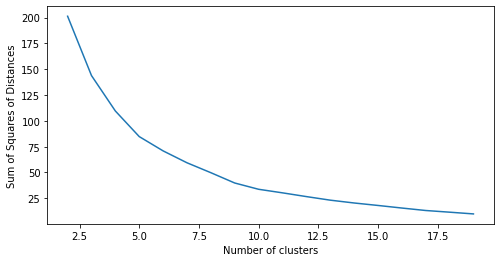

In [55]:
Sum_Squares = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(DF_Clust)
    Sum_Squares.append(kmeans.inertia_)

fig = plt.figure(figsize=(8,4))
plt.plot(range(2, 20), Sum_Squares)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squares of Distances')
plt.show()

From above plot, 8 or 9 number of clusters appear to be the optimum number of clusters

#**Interpretation of Results and Visualizations**

<ipython-input-56-ea7307d582a1>:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_mat=hcl.linkage(distance_matrix,method='centroid')


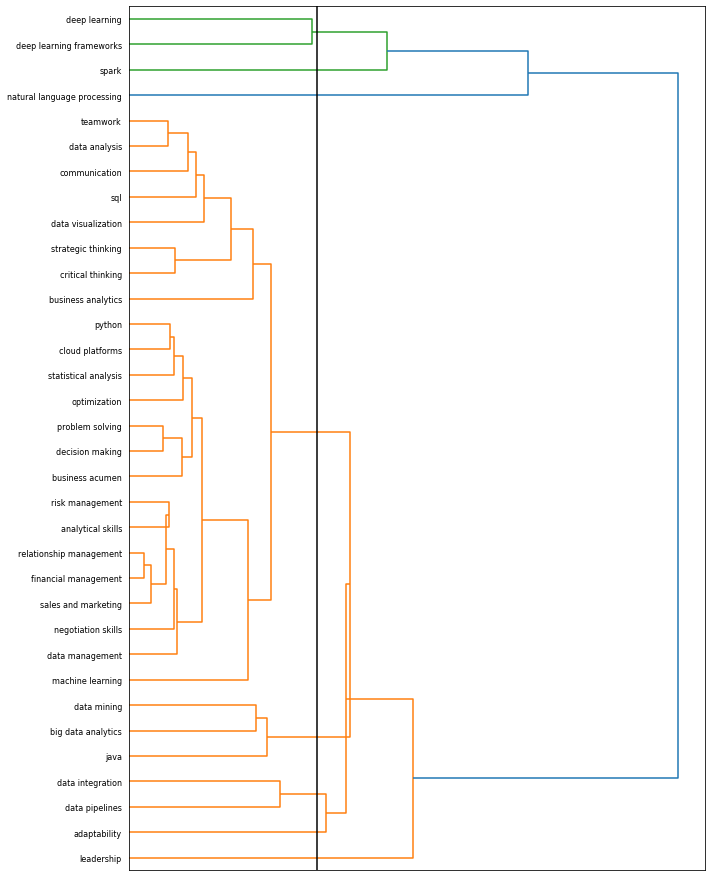

In [56]:
# Part a
# Dendrogram from Hierarchical Clustering
linkage_mat=hcl.linkage(distance_matrix,method='centroid')

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])

Dngm = hcl.dendrogram(linkage_mat, orientation='right')

labels = distance_matrix.columns[Dngm['leaves']]

ax1.set_xticks([])
ax1.set_yticklabels(labels)
plt.plot()
x=np.ones(500)*24
y=np.arange(0,500,1)
plt.plot(x,y,color='black')
plt.show()

In [57]:
# Part b
# Scatter Plot for kmeans clustering

kmeans = KMeans(n_clusters=8,random_state=0)
kmeans.fit(DF_Clust)
labels = kmeans.labels_ 
X = PCA(2).fit_transform(DF_Clust)

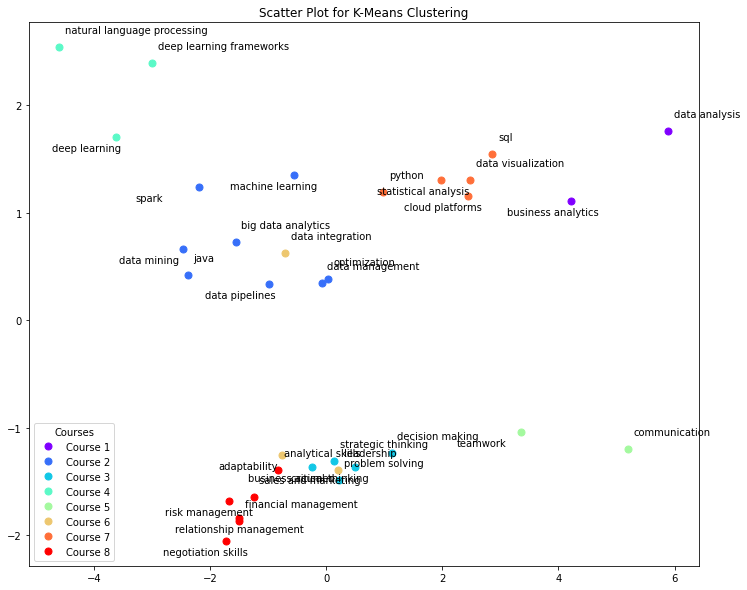

In [58]:
cmap = plt.cm.get_cmap('rainbow', 8)
labels_=['Course '+str(i+1) for i in range(8)]
fig = plt.figure(figsize=(12,10))
for i in range(0, len(np.unique(labels))):
  idx=(labels==i)
  plt.plot(X[idx][:, 0], X[idx][:, 1],linewidth=0,marker='o',markersize=7, c=cmap(i),label=labels_[i])
  s=DF_Skills[idx]['Skill'].values
  X_=X[idx]
  for k in range(0,len(s)):
    if k%2!=0 :
      m=-0.1
    else:
      m=0.1
    plt.text(X_[:, 0][k]+m*6-0.5,X_[:, 1][k]+m*1.3,s[k])
    

plt.title('Scatter Plot for K-Means Clustering')
plt.legend(title='Courses')
plt.show()

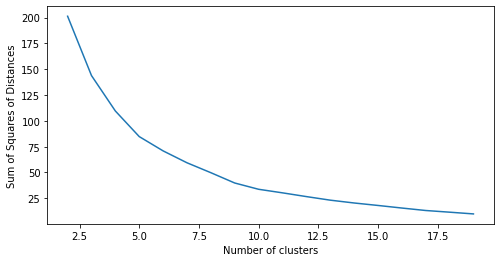

In [59]:
# Part c
# Elbow Method

Sum_Squares = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(DF_Clust)
    Sum_Squares.append(kmeans.inertia_)

fig = plt.figure(figsize=(8,4))
plt.plot(range(2, 20), Sum_Squares)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squares of Distances')
plt.show()

#**Part 6 : Discussion and Final Course Curriculum**

Our Final Course Cuuriculum is as given by K-Means Clustering Algorithm,

Course 1 : Data analysis, Business analytics

Course 2 : Optimization, Machine learning, Data management, Data pipelines,
          Big Data analytics, Data Mining, Java, Spark     

Course 3 : Decision Making, Critical Thinking, Problem solving, Business Acumen, Strategic Thinking   

Course 4 : Deep Learning, Deep Learning Frameworks, Natural language processing        

Course 5 : Communication, Team-work    

Course 6 : Leadership, Adaptability, Data Integration    

Course 7 : SQL, Cloud Platforms, Data Visualization, Statistical Analysis, Python   

Course 8 : Financial Management, Relationship Management, Sales and Marketing, 
 Negotiation Skills, Analytical Skills, Risk Management

**Discussion on obtained course curriculum**

The above curriculum obtained seems to be a very reasonable one.     

Course 1 is the Data Analytics Course which will cover the fundamental aspects of data analytics.      
Course 2 is a Big Data Course which will cover all aspects of Big Data Architecture, tools for Big Data processing such as Spark, and Data Management and Data Movement techniques. This is very similar to MIE 1628 at UofT     
Course 3 is the Business Strategy Equivalent course which is covering aspects such as Decision Making and Strategic Thinking   
Course 4 is about Neural Networks and their Applications such as NLP     
Course 5 is about essential skills in the work environment emphasising on team-work and communication, which seem to be the most sought after skills in data jobs as these were the skills with top frequencies after data analysis.   
Course 6 Business Management equivalent course focussing on managerial aspects such as adaptability and leadership   
Course 7 is the Data Science course, which is resonating closely with MIE1624 at UofT   
Course 8 is the core Business Skills course, which can intuitively be interpreted as a mini MBA

#**OpenAI to Describe Clustering Results**

In [60]:
DF_=DF_Skills.copy(deep=True)
DF_['Labels']=labels
Results={}
for i in range(0, max(labels)+1):
  Results['Cluster '+ str(i+1)]= ', '.join(list(DF_[(DF_['Labels']==i)]['Skill'].values))

In [61]:
Results

{'Cluster 1': 'data analysis, business analytics',
 'Cluster 2': 'optimization, machine learning, data management, data pipelines, big data analytics, data mining, java, spark',
 'Cluster 3': 'decision making, critical thinking, problem solving, business acumen, strategic thinking',
 'Cluster 4': 'deep learning frameworks, deep learning, natural language processing',
 'Cluster 5': 'communication, teamwork',
 'Cluster 6': 'leadership, adaptability, data integration',
 'Cluster 7': 'sql, cloud platforms, data visualization, statistical analysis, python',
 'Cluster 8': 'financial management, relationship management, sales and marketing, negotiation skills, analytical skills, risk management'}

In [62]:
# Asking Chat-GPT for interpretation of results

#prompt=('I did a clustering exercise on a dataset of job descriptions related to  \n '  
#        'data science, management,busines, analyst, data engineer etc. related roles.  \n' 
#        'I extratced the technical(hard skills) skills and business(soft skills) skills, \n '
#        'from the job descriptions, did feature engineering and prepared a data set of  '
#        '34 skills with 10 features. \n Then, I performed K Means clustering to group'
#        'these skills into 8 clusters and obtained following as the result: \n {result}  \n'
#        'Can you please comment on whether you find these clusters meaningful? \n'
#        'what do you think each cluster represents?')
#prompt=prompt.format(result=Results)

#response = openai.ChatCompletion.create(
#      model="gpt-3.5-turbo",
#      messages=[
#      {"role": "system", "content": "You are a helpful  assistant."},
#      {"role": "user", "content": prompt},
#      ],
#      max_tokens=1024,
#      n=1,
#      stop=None,
#      temperature=0.5,
#      )

#if response["choices"][0]["finish_reason"] == "error":
#  output=''
#else:
#  output = response['choices'][0]['message']['content']
#  print(output)


In [63]:
# Hard Coding Response of OpenAI API
Response='''
Based on the information you have provided, the clusters seem to be meaningful and representative of different skill sets. 

Cluster 1 appears to be focused on data analysis and business analytics, which are essential for understanding business performance and making data-driven decisions.

Cluster 2 includes technical skills such as optimization, machine learning, data management, data pipelines, big data analytics, data mining, java, and spark. These skills are crucial for data engineering and building data-driven solutions.

Cluster 3 seems to be focused on soft skills such as decision making, critical thinking, problem-solving, business acumen, and strategic thinking. These skills are important for making informed decisions and driving business growth.

Cluster 4 appears to be focused on deep learning frameworks, deep learning, and natural language processing. These skills are essential for building advanced machine learning models and natural language processing applications.

Cluster 5 includes soft skills such as communication and teamwork, which are important for collaboration and effective communication within teams.

Cluster 6 seems to be focused on leadership, adaptability, and data integration. These skills are important for managing teams and integrating data from different sources.

Cluster 7 includes technical skills such as SQL, cloud platforms, data visualization, statistical analysis, and Python. These skills are essential for data analysis and building data-driven solutions.

Cluster 8 appears to be focused on business skills such as financial management, relationship management, sales and marketing, negotiation skills, analytical skills, and risk management. These skills are important for managing business operations and driving growth. 

Overall, the clusters seem to be meaningful and representative of different skill sets required for data science, management, business, analyst, and data engineer roles.
'''

In [64]:
print(Response)


Based on the information you have provided, the clusters seem to be meaningful and representative of different skill sets. 

Cluster 1 appears to be focused on data analysis and business analytics, which are essential for understanding business performance and making data-driven decisions.

Cluster 2 includes technical skills such as optimization, machine learning, data management, data pipelines, big data analytics, data mining, java, and spark. These skills are crucial for data engineering and building data-driven solutions.

Cluster 3 seems to be focused on soft skills such as decision making, critical thinking, problem-solving, business acumen, and strategic thinking. These skills are important for making informed decisions and driving business growth.

Cluster 4 appears to be focused on deep learning frameworks, deep learning, and natural language processing. These skills are essential for building advanced machine learning models and natural language processing applications.

Cl